
## Análisis y Segmentación de Miembros (Punto 1 - Prueba Técnica)


In [3]:

import sys
sys.path.append("..") 
import pandas as pd
import numpy as np
from src.utils import reduce_pca
from src.cltv_engagement import calculate_engagement, estimate_cltv
from src.segmentation import segment_members, plot_segments
from sklearn.decomposition import PCA

df = pd.read_csv("D:/voiceflip/notebooks/data/processed/churn_encoded.csv")
# 1. Verificación EXTRA
print("=== Verificación Final ===")
pc_data = df[[col for col in df.columns if str(col).startswith('PC')]].copy()
print(f"Datos PC shape: {pc_data.shape}")
print(f"Valores nulos: {pc_data.isnull().sum().sum()}")
print(f"Valores infinitos: {np.isinf(pc_data.values).sum()}")

# 2. Conversión EXPLÍCITA
pc_data = pc_data.astype(np.float64)

# 3. Ejecución SEGURA
try:
    print("\nEjecutando PCA definitivo...")
    pca = PCA(n_components=min(50, pc_data.shape[1]))
    df_pca = pd.DataFrame(
        pca.fit_transform(pc_data),
        columns=[f"PC_{i}" for i in range(min(50, pc_data.shape[1]))]
    )
    print("¡Éxito! Resultados PCA:")
    print(df_pca.head())
except Exception as e:
    print(f"\nError crítico: {e}")
    print("\nSolución de emergencia (SVD):")
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=50)
    df_pca = pd.DataFrame(svd.fit_transform(pc_data))
    print("Resultado con SVD:")
    print(df_pca.head())

=== Verificación Final ===
Datos PC shape: (11896, 160)
Valores nulos: 0
Valores infinitos: 0

Ejecutando PCA definitivo...
¡Éxito! Resultados PCA:
       PC_0      PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
0 -3.064007 -1.272259 -4.075844  1.492514  2.328039 -0.330240 -0.770389   
1 -4.574066 -3.541815  1.107371  0.447314 -0.471140 -0.567309  0.195963   
2 -1.751471 -2.039692 -3.788823  0.624226  0.564614 -0.713385  1.003502   
3 -2.030089 -0.235720 -5.711960  1.071841  2.441541  0.758484 -0.534295   
4 -2.377857 -2.478670 -1.051946  2.812768  2.019267  0.095542 -0.033324   

       PC_7      PC_8      PC_9  ...     PC_40     PC_41     PC_42     PC_43  \
0  0.035541  2.439325 -0.847266  ... -0.393532 -0.343193  0.227923  0.084643   
1  0.383654  1.523472 -0.184596  ... -0.225498 -0.286440 -0.115011  0.335358   
2  1.582819 -1.461687  0.844975  ... -0.355046  0.209236 -0.055678 -0.026064   
3  1.614289 -1.022909 -1.383025  ...  0.478267 -0.065440  0.610210 -0.556117   
4

## 2. CÁLCULO DE ENGAGEMENT

In [4]:
# Pesos para las 4 componentes principales (PC_0 es la más importante)
weights = {'PC_0': 0.5, 'PC_1': 0.3, 'PC_2': 0.15, 'PC_3': 0.05}

# Calcular engagement
df['engagement'] = sum(df_pca[col] * weight for col, weight in weights.items())

# Normalizar entre 0-100 (opcional)
df['engagement'] = (df['engagement'] - df['engagement'].min()) / (df['engagement'].max() - df['engagement'].min()) * 100

## 3. CÁLCULO DE CLTV

In [5]:
from sklearn.linear_model import LogisticRegression

# Entrenar modelo para predecir churn
model = LogisticRegression(max_iter=2000)
model.fit(df_pca, df['y'])  # Usa las componentes PCA

# Predecir probabilidad
df['churn_probability'] = model.predict_proba(df_pca)[:, 1]  # Probabilidad de que abandone (1)

# Calcular CLTV (fórmula simplificada)
df['cltv'] = (1 - df['churn_probability']) * df['engagement'] * 1000  # 1000 = valor estimado

## 4. SEGMENTACIÓN CON K-MEANS

In [6]:
from sklearn.cluster import KMeans

# Datos para clustering (engagement + CLTV)
X = df[['engagement', 'cltv']].values

# Estandarizar y aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
df['segment'] = kmeans.fit_predict(X)

# Ver resultados
print(df.groupby('segment')[['engagement', 'cltv', 'churn_probability']].mean().round(2))

         engagement      cltv  churn_probability
segment                                         
0              5.21   5009.15               0.03
1             18.53  17768.70               0.04
2             11.50  11135.63               0.03
3             28.08  26871.50               0.04


## 5. VISUALIZACIÓN

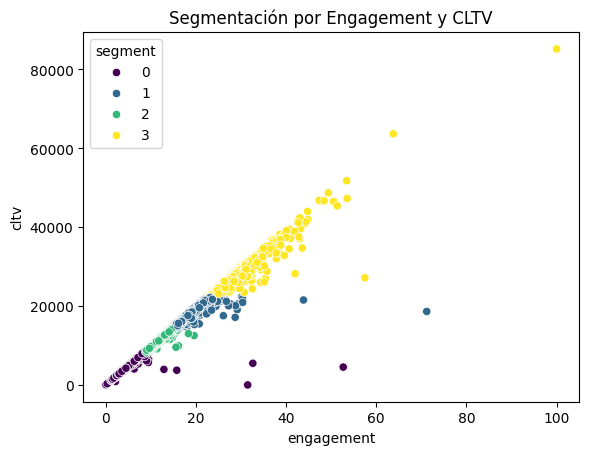

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='engagement', y='cltv', hue='segment', palette='viridis')
plt.title('Segmentación por Engagement y CLTV')
plt.savefig('segmentos.png')  # Para tu reporte

In [8]:
# Verifica la discrepancia con el churn real (0/1)
churn_real = df['y'].mean() * 100  # % real de clientes que abandonaron
churn_prob_avg = df['churn_probability'].mean() * 100  # % promedio predicho

print(f"Churn real: {churn_real:.2f}%")
print(f"Churn predicho (avg): {churn_prob_avg:.2f}%")
print(f"Suma probabilidades: {df['churn_probability'].sum() * 100 / len(df):.2f}%")

Churn real: 3.43%
Churn predicho (avg): 3.43%
Suma probabilidades: 3.43%


In [9]:
from sklearn.metrics import roc_auc_score
print("AUC-ROC:", roc_auc_score(df['y'], df['churn_probability']))

AUC-ROC: 0.7108018085367853


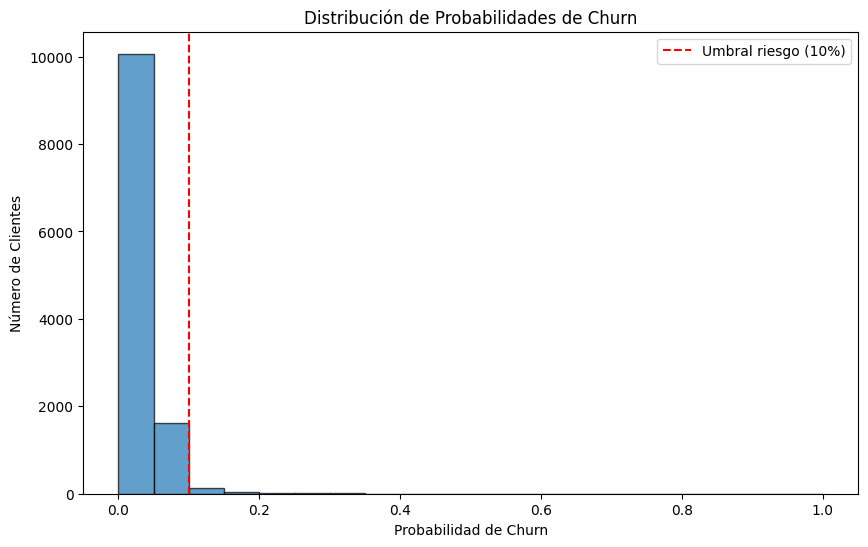

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['churn_probability'], bins=20, edgecolor='k', alpha=0.7)
plt.axvline(x=0.1, color='r', linestyle='--', label='Umbral riesgo (10%)')
plt.title('Distribución de Probabilidades de Churn')
plt.xlabel('Probabilidad de Churn')
plt.ylabel('Número de Clientes')
plt.legend()
plt.show()

In [11]:
df['risk_group'] = pd.cut(df['churn_probability'],
                         bins=[0, 0.05, 0.1, 0.3, 1],
                         labels=['Bajo', 'Medio', 'Alto', 'Crítico'])

<Axes: xlabel='risk_group'>

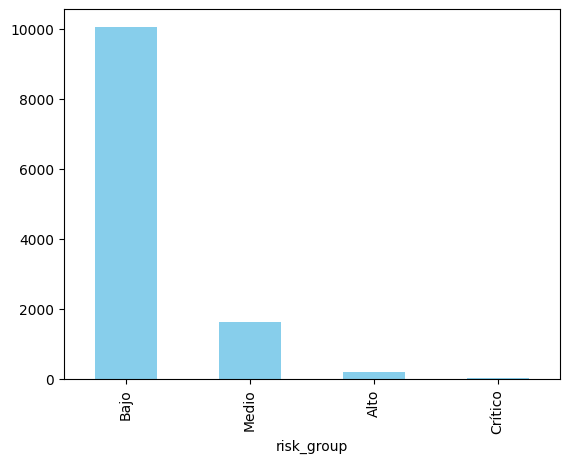

In [12]:
df['risk_group'].value_counts().plot(kind='bar', color='skyblue')

In [13]:
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,FACTOR18_V4,FACTOR18_V5,FACTOR18_V6,FACTOR18_V7,FACTOR18_V8,engagement,churn_probability,cltv,segment,risk_group
0,-3.064007,-1.272259,-4.075844,1.492514,2.328039,-0.330240,-0.770389,0.035541,2.439325,-0.847266,...,True,False,False,False,False,4.457306,0.032451,4312.661925,0,Bajo
1,-4.574066,-3.541815,1.107371,0.447314,-0.471140,-0.567309,0.195963,0.383654,1.523472,-0.184596,...,True,False,False,False,False,2.285894,0.028348,2221.093445,0,Bajo
2,-1.751471,-2.039692,-3.788823,0.624226,0.564614,-0.713385,1.003502,1.582819,-1.461687,0.844975,...,True,False,False,False,False,5.757930,0.021357,5634.960424,0,Bajo
3,-2.030089,-0.235720,-5.711960,1.071841,2.441541,0.758484,-0.534295,1.614289,-1.022909,-1.383025,...,True,False,False,False,False,6.172834,0.019399,6053.090147,0,Bajo
4,-2.377857,-2.478670,-1.051946,2.812768,2.019267,0.095542,-0.033324,-1.332319,4.316526,-0.537967,...,False,False,False,False,False,5.987307,0.028702,5815.457579,0,Bajo


In [14]:
df.to_csv("D:/voiceflip/notebooks/data/processed/churn_segmented.csv", index=False)